In [ ]:
# Import required packages
from transformers import pipeline, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

torch.cuda.is_available()

# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Import for text analytics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# Import metrics libraries
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
interactions_train = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/interactions_train.csv')
items = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/items.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/halim-y/DSML_Kaggle_Competition/refs/heads/main/data/raw/sample_submission.csv')

In [ ]:
interactions_train.head()

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


In [ ]:
items.head()

,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [ ]:
sample_submission.head()

,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [ ]:
print(interactions_train['i'].isin(items['i']).mean())

1.0


Since it returns 1.0, we know that "i" is indeed the item/book ID.

Let's rename our columns for more clarity

In [ ]:
interactions_train = interactions_train.rename(columns={
    'u': 'user_id',
    'i': 'item_id',
    't': 'timestamp'
})
items = items.rename(columns={'i': 'item_id'})

In [ ]:
interactions_train.head()

,user_id,item_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


# 1. Interaction_train

`interactions.csv` – user–item interaction history (who borrowed what)

In [ ]:
print('>>> Shape:\n', interactions_train.shape)
print('\n>>> Columns:\n',interactions_train.columns)
print('\n>>> dtypes:\n',interactions_train.dtypes)
print('\n>>> Describe:\n',interactions_train.describe())
print('\n>>> NaN-values:\n',interactions_train.isna().sum())
print('\n>>> Duplicates:\n',interactions_train.duplicated().sum())

>>> Shape:
 (87047, 3)

>>> Columns:
 Index(['user_id', 'item_id', 'timestamp'], dtype='object')

>>> dtypes:
 user_id        int64
item_id        int64
timestamp    float64
dtype: object

>>> Describe:
             user_id       item_id     timestamp
count  87047.000000  87047.000000  8.704700e+04
mean    3290.827898   6804.254598  1.695743e+09
std     2266.663449   4441.228450  1.419829e+07
min        0.000000      0.000000  1.672664e+09
25%     1309.000000   2843.000000  1.683051e+09
50%     2831.000000   6482.000000  1.695917e+09
75%     5162.000000  10620.000000  1.707222e+09
max     7837.000000  15290.000000  1.728925e+09

>>> NaN-values:
 user_id      0
item_id      0
timestamp    0
dtype: int64

>>> Duplicates:
 2


In [ ]:
interactions_train.drop_duplicates(inplace=True)
print('\n>>> Duplicates:\n',interactions_train.duplicated().sum())


>>> Duplicates:
 0


In [ ]:
display(interactions_train)

,user_id,item_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09
...,...,...,...
87042,924,8171,1.699284e+09
87043,1106,9009,1.699872e+09
87044,5207,13400,1.683627e+09
87045,698,5779,1.686667e+09


In [ ]:
print('>>> Number of unique users:', len(interactions_train['user_id'].unique()))
print('>>> Number of unique items:', len(interactions_train['item_id'].unique()))

>>> Number of unique users: 7838
>>> Number of unique items: 15109


## User-Item Interaction

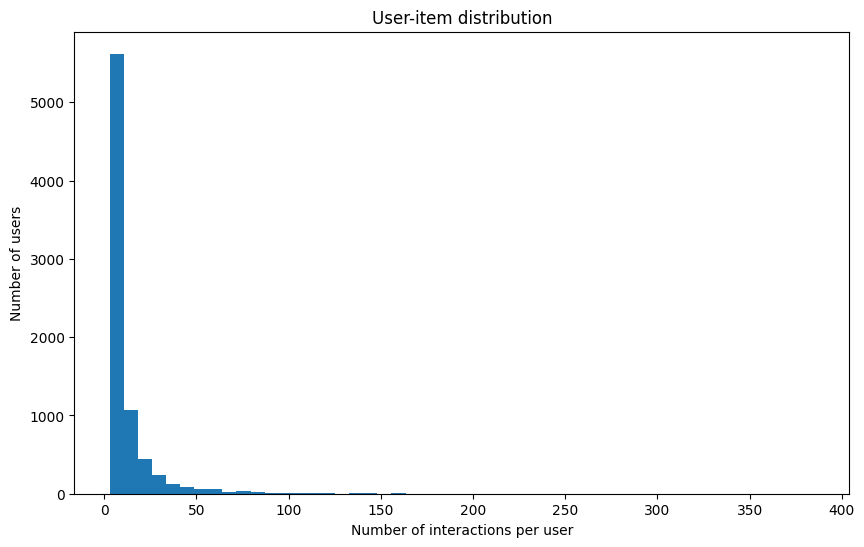

In [ ]:
user_counts = interactions_train['user_id'].value_counts()

# Vizualize user-item distribution
plt.figure(figsize=(10, 6))
plt.hist(user_counts, bins=50)
plt.xlabel('Number of interactions per user')
plt.ylabel('Number of users')
plt.title('User-item distribution')
plt.show()

The data is Right-skewed shape, meaning it is sparses and we have many casual users and few power users.

This is a sign we might need collaborative-filtering

In [ ]:
print(user_counts.describe())

count    7838.000000
mean       11.105512
std        16.441830
min         3.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       385.000000
Name: count, dtype: float64


In [ ]:
def bucketize_counts(counts):
    bins = [0, 3, 10, 30, 50, 100, 200, counts.max()]
    labels = ["1–3", "4–10", "11–30","31-50", "51-100", "101-200", '200+']
    return pd.cut(counts, bins=bins, labels=labels, include_lowest=True)

user_buckets = bucketize_counts(user_counts)
print(user_buckets.value_counts(normalize=True).sort_index() * 100)

count
1–3        31.194182
4–10       40.520541
11–30      21.446798
31-50       3.661648
51-100      2.551671
101-200     0.599643
200+        0.025517
Name: proportion, dtype: float64


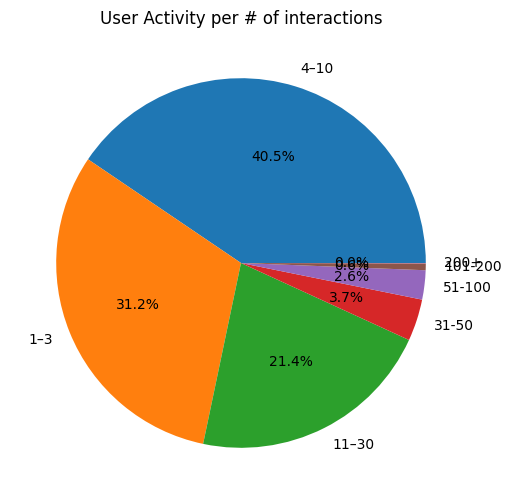

In [ ]:
user_buckets.value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6))
plt.title("User Activity per # of interactions")
plt.ylabel("")
plt.show()

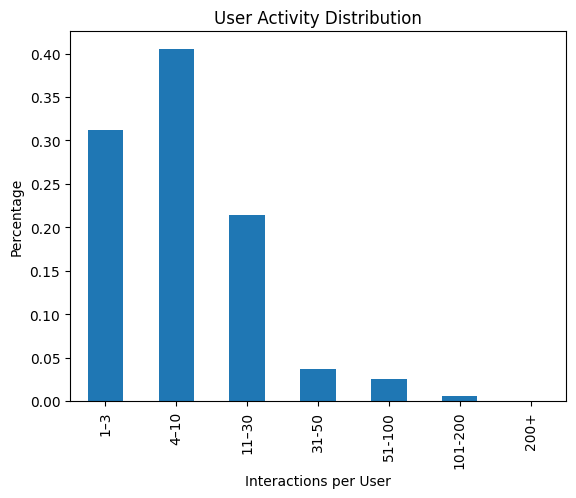

In [ ]:
user_buckets.value_counts(normalize=True).sort_index().plot.bar()
plt.title("User Activity Distribution")
plt.xlabel("Interactions per User")
plt.ylabel("Percentage")
plt.show()

In [ ]:
for number_of_interaction in range(1, user_counts.max()):
  percentage_of_users = (user_counts == number_of_interaction).mean()*100
  if percentage_of_users > 1:
    print(f">>> Users with only {number_of_interaction} interaction: {percentage_of_users:.2f}%")

>>> Users with only 3 interaction: 31.19%
>>> Users with only 4 interaction: 9.59%
>>> Users with only 5 interaction: 6.89%
>>> Users with only 6 interaction: 6.12%
>>> Users with only 7 interaction: 8.74%
>>> Users with only 8 interaction: 3.47%
>>> Users with only 9 interaction: 3.05%
>>> Users with only 10 interaction: 2.65%
>>> Users with only 11 interaction: 4.03%
>>> Users with only 12 interaction: 1.59%
>>> Users with only 13 interaction: 1.52%
>>> Users with only 14 interaction: 1.40%
>>> Users with only 15 interaction: 2.54%
>>> Users with only 19 interaction: 1.35%
>>> Users with only 23 interaction: 1.24%


Top 10 most active users:

In [ ]:
user_counts.sort_values(ascending=False).head(10)

,count
user_id,
6869,385
4473,254
1884,200
732,199
1744,175
1106,165
262,163
2648,162
7507,157


**What does the data say ?**

| Bucket      | Meaning             | % of Users |
| ----------- | ------------------- | ---------- |
| **3**     | Very low activity   | **31.19%** |
| **4–10**    | Low–medium activity | **40.52%** |
| **11–30**   | Medium activity     | **21.45%** |
| **31–50**   | High activity       | **3.66%**  |
| **51–100**  | Very high activity  | **2.55%**  |
| **101–200** | Power users         | **0.60%**  |
| **200+**    | Extreme power users | **0.03%**  |


**Interpretation :**

* The median is only 6 interaction per users.
* **71.71%** of users have 10 or fewer interactions → extremely sparse user histories.
* Only **6.84%** of users have more than 30 interactions.
* Extreme power users exist but account for less than **0.1%**.

This pattern is consistent with real-world recommender systems:
most users interact infrequently, and a small minority interact very frequently. This also means *Collaborative Filtering* will struggle for ~72% of users as these "cold" user supply too feww interactions for user-user similarity, matrix factorization or neighborhood methods.


**Solution** → We will rely on `items.csv` for **content-based** models.  




## Items

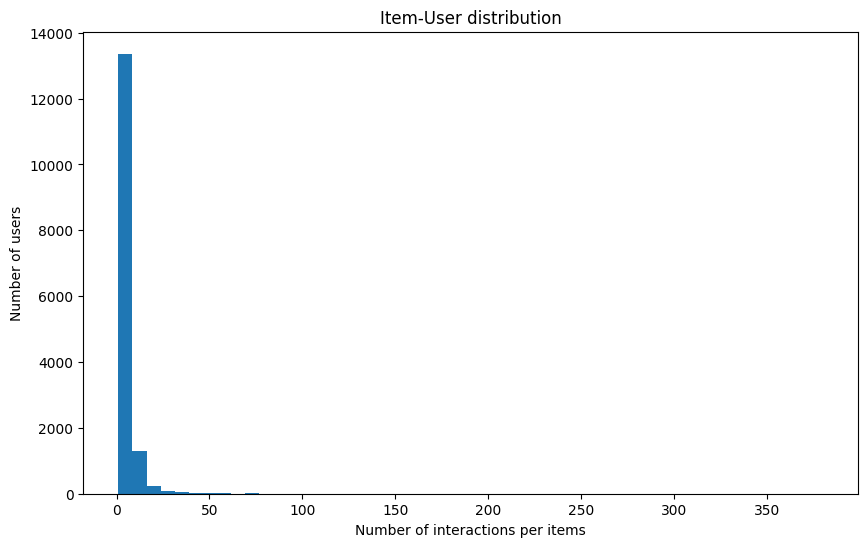

In [ ]:
item_counts  = interactions_train['item_id'].value_counts()

# Vizualize user-item distribution
plt.figure(figsize=(10, 6))
plt.hist(item_counts , bins=50)
plt.xlabel('Number of interactions per items')
plt.ylabel('Number of users')
plt.title('Item-User distribution')
plt.show()

In [ ]:
print(item_counts.describe())

count    15109.000000
mean         5.761136
std          9.004665
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        380.000000
Name: count, dtype: float64


In [ ]:
item_buckets = bucketize_counts(item_counts)
print(item_buckets.value_counts(normalize=True).sort_index() * 100)

count
1–3        30.425574
4–10       62.399894
11–30       6.254550
31-50       0.503011
51-100      0.258124
101-200     0.125753
200+        0.033093
Name: proportion, dtype: float64


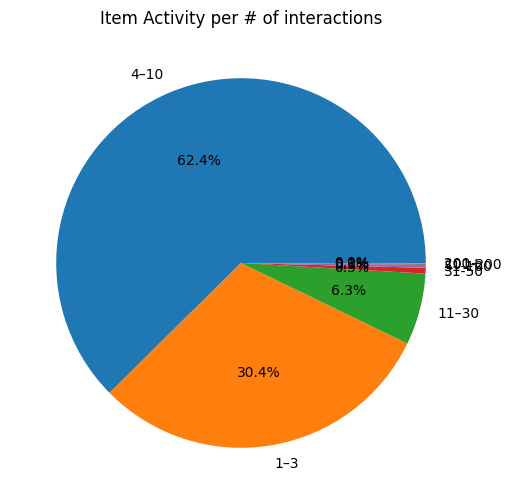

In [ ]:
item_buckets.value_counts().plot.pie(autopct='%1.1f%%', figsize=(6,6))
plt.title("Item Activity per # of interactions")
plt.ylabel("")
plt.show()

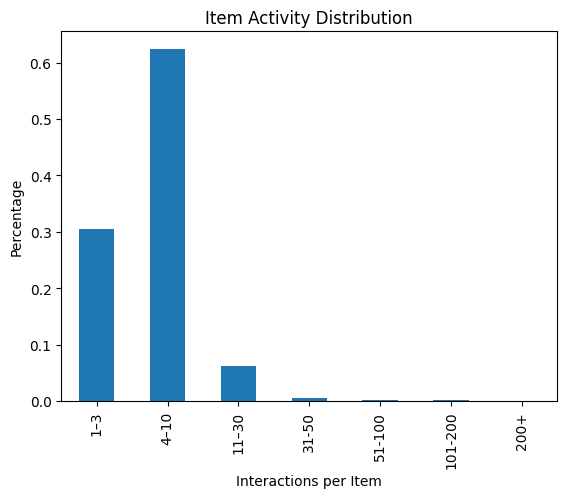

In [ ]:
item_buckets.value_counts(normalize=True).sort_index().plot.bar()
plt.title("Item Activity Distribution")
plt.xlabel("Interactions per Item")
plt.ylabel("Percentage")
plt.show()

In [ ]:
for number_of_interaction in range(1, 386):
  percentage_of_items = (item_counts == number_of_interaction).mean()*100
  if percentage_of_items > 1:
    print(f">>> Items with only {number_of_interaction} interaction: {percentage_of_items:.2f}%")

>>> Items with only 1 interaction: 4.58%
>>> Items with only 2 interaction: 9.26%
>>> Items with only 3 interaction: 16.59%
>>> Items with only 4 interaction: 21.81%
>>> Items with only 5 interaction: 16.90%
>>> Items with only 6 interaction: 9.97%
>>> Items with only 7 interaction: 5.70%
>>> Items with only 8 interaction: 3.65%
>>> Items with only 9 interaction: 2.49%
>>> Items with only 10 interaction: 1.89%
>>> Items with only 11 interaction: 1.29%


Top 10 items with unusually high counts

In [ ]:
item_counts.sort_values(ascending=False).head(10)

,count
item_id,
11366,380
3055,357
10715,305
8999,257
611,217
4426,189
53,178
2820,177
14555,151


**What does the data say ?**

| Bucket      | Meaning               | % of Items |
| ----------- | --------------------- | ---------- |
| **1–3**     | Very low popularity   | **30.43%** |
| **4–10**    | Low–medium popularity | **62.40%** |
| **11–30**   | Medium popularity     | **6.25%**  |
| **31–50**   | High popularity       | **0.50%**  |
| **51–100**  | Very high popularity  | **0.26%**  |
| **100–200** | Extremely popular     | **0.13%**  |
| **200+**    | Best-sellers          | **0.03%**  |

**Interpretation :**

* The median is only 4 interactions per item.
* **92.83%** of items have between 1 and 10 interactions.
* Only **6.84%** of users have more than 30 interactions.
* Very few items very popular, only **0.16%**.

While items are not as extremely sparse as users (many users have between 1 and 3 interactions), each item still has relatively few signals on average that limits how well pure collaborative methods can learn high-quality item representations for a large fraction of items.


**Solution** → We will rely on `items.csv` for **content-based** models.  

## Timestamp

In [ ]:
interactions_train['datetime'] = pd.to_datetime(interactions_train['timestamp'], unit='s')
interactions_train['year'] = interactions_train['datetime'].dt.year
interactions_train['month'] = interactions_train['datetime'].dt.month
interactions_train['day'] = interactions_train['datetime'].dt.day
interactions_train['week'] = interactions_train['datetime'].dt.isocalendar().week
interactions_train['day_of_week'] = interactions_train['datetime'].dt.dayofweek  # Monday=0
interactions_train

,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,25,4
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,12,3
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,5,4
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,2,3
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,15,3
...,...,...,...,...,...,...,...,...,...
87042,924,8171,1.699284e+09,2023-11-06 15:15:47,2023,11,6,45,0
87043,1106,9009,1.699872e+09,2023-11-13 10:48:13,2023,11,13,46,0
87044,5207,13400,1.683627e+09,2023-05-09 10:02:52,2023,5,9,19,1
87045,698,5779,1.686667e+09,2023-06-13 14:37:48,2023,6,13,24,1


In [ ]:
# Basic timestamp stats
print(">>> Min timestamp:", interactions_train['timestamp'].min())
print("\n>>> Max timestamp:", interactions_train['timestamp'].max())
print("\n>>> Date Minimum:",interactions_train['datetime'].min())
print("\n>>> Date Maximum:",interactions_train['datetime'].max())

>>> Min timestamp: 1672663643.0

>>> Max timestamp: 1728925054.0

>>> Date Minimum: 2023-01-02 12:47:23

>>> Date Maximum: 2024-10-14 16:57:34



>>> Monthly: datetime
2023-01    5466
2023-02    5532
2023-03    5927
2023-04    4345
2023-05    4989
2023-06    5249
2023-07    3495
2023-08    3852
2023-09    5065
2023-10    4990
2023-11    5220
2023-12    4598
2024-01    5642
2024-02    5699
2024-03    4502
2024-04    3729
2024-05    3035
2024-06    2262
2024-07    1088
2024-08    1055
2024-09     984
2024-10     321
Freq: M, Name: count, dtype: int64

>>> Nunber of month: 22


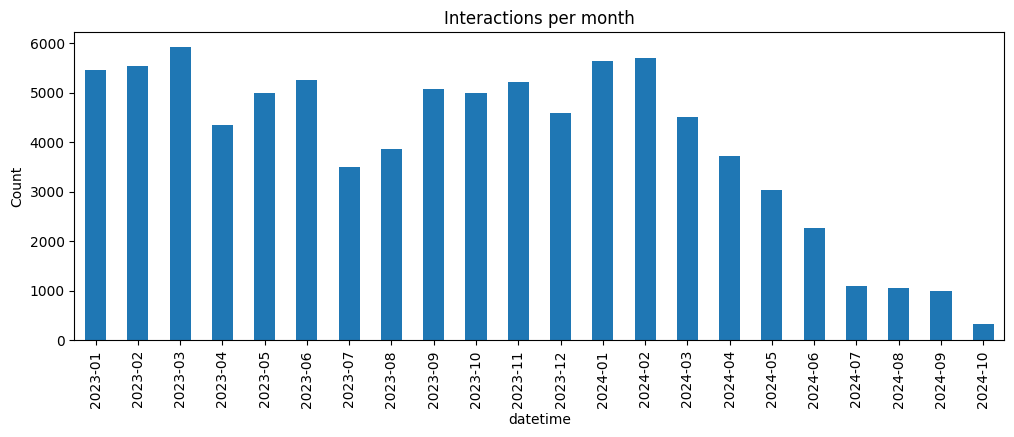

In [ ]:
# Interactions per month
monthly = interactions_train['datetime'].dt.to_period('M').value_counts().sort_index()
print("\n>>> Monthly:", monthly)
print("\n>>> Nunber of month:", len(monthly))

monthly.plot(kind='bar', figsize=(12,4))
plt.title("Interactions per month")
plt.ylabel("Count")
plt.show()

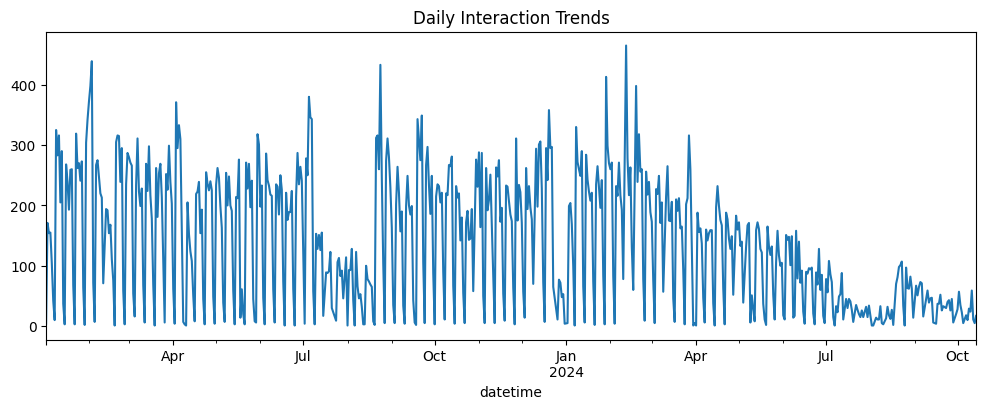

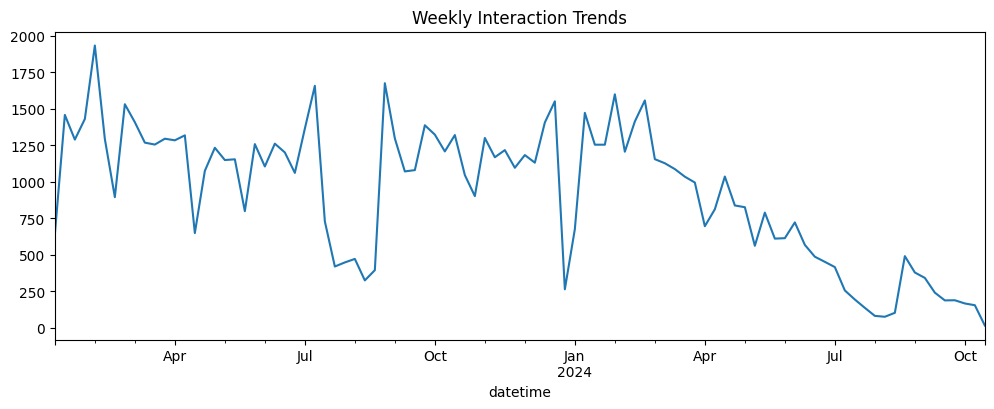

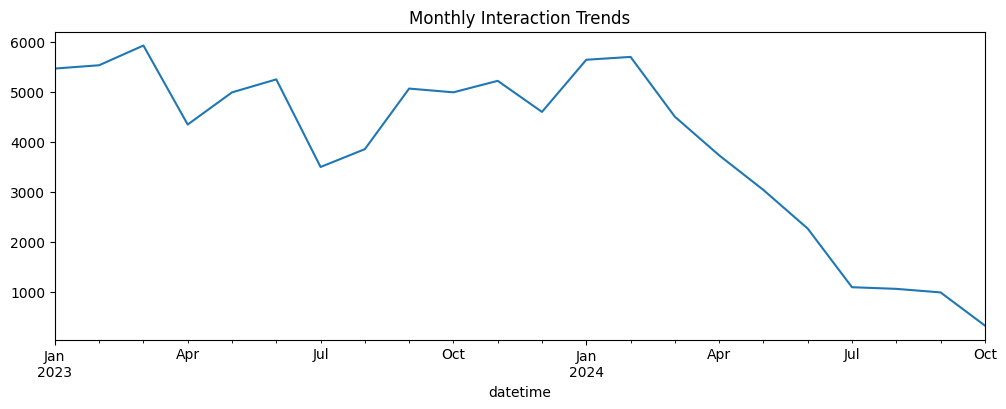

In [ ]:
daily = interactions_train['datetime'].dt.to_period('D').value_counts().sort_index()
daily.plot(figsize=(12,4), title='Daily Interaction Trends')
plt.show()

weekly = interactions_train['datetime'].dt.to_period('W').value_counts().sort_index()
weekly.plot(figsize=(12,4), title='Weekly Interaction Trends')
plt.show()

monthly = interactions_train['datetime'].dt.to_period('M').value_counts().sort_index()
monthly.plot(figsize=(12,4), title='Monthly Interaction Trends')
plt.show()

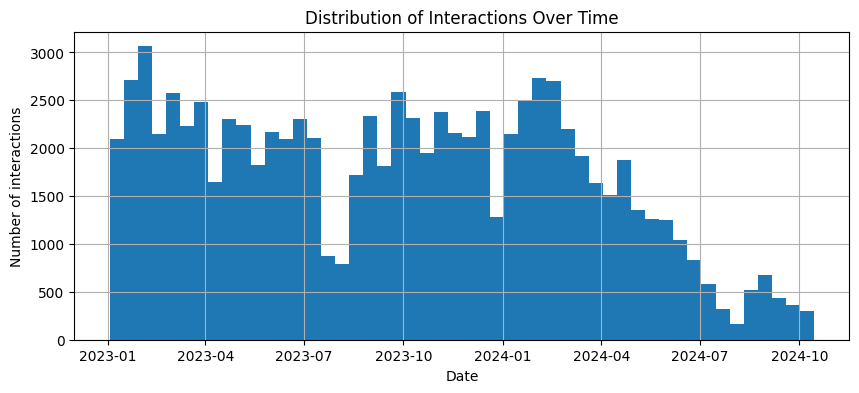

In [ ]:
# Shows density of interactions across all dates.
plt.figure(figsize=(10,4))
interactions_train['datetime'].hist(bins=50)
plt.title('Distribution of Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of interactions')
plt.show()

## Recency

In [ ]:
# Computes how “old” each interaction is relative to the dataset end
latest_ts = interactions_train['timestamp'].max()
interactions_train['time_diff'] = latest_ts - interactions_train['timestamp']
interactions_train

,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,25,4,41383968.0
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,12,3,49339648.0
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,5,4,22053395.0
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,2,3,55391892.0
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,15,3,47522892.0
...,...,...,...,...,...,...,...,...,...,...
87042,924,8171,1.699284e+09,2023-11-06 15:15:47,2023,11,6,45,0,29641307.0
87043,1106,9009,1.699872e+09,2023-11-13 10:48:13,2023,11,13,46,0,29052561.0
87044,5207,13400,1.683627e+09,2023-05-09 10:02:52,2023,5,9,19,1,45298482.0
87045,698,5779,1.686667e+09,2023-06-13 14:37:48,2023,6,13,24,1,42257986.0


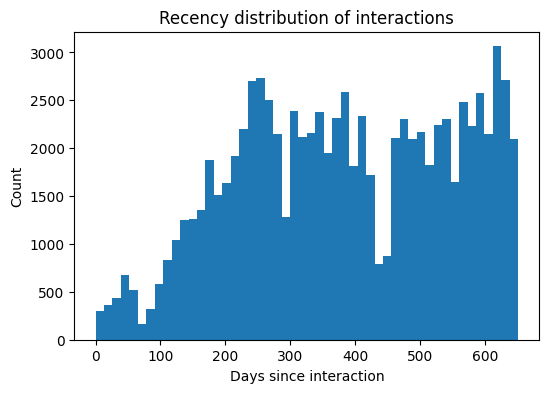

In [ ]:
# Plot how many interactions happened X days ago.
plt.figure(figsize=(6,4))
plt.hist(interactions_train['time_diff']/86400, bins=50) # convert seconds to days
plt.xlabel('Days since interaction')
plt.ylabel('Count')
plt.title('Recency distribution of interactions')
plt.show()

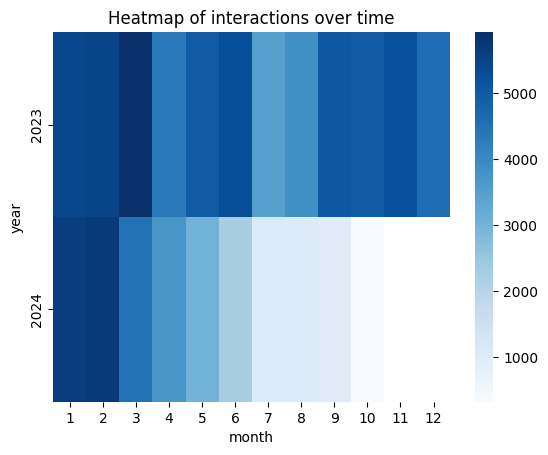

In [ ]:
#Interactions by year-month
pivot = interactions_train.pivot_table(index='year', columns='month', values='user_id', aggfunc='count')
sns.heatmap(pivot, annot=False, cmap='Blues')
plt.title("Heatmap of interactions over time")
plt.show()

**What does the data say ?**

* **Earliest interaction:** January 2nd, 2023
* **Latest interaction:** October 14th, 2024
* Activity is relatively stable during all of 2023, with monthly interactions between **4,300** and **5,900**.
* **Peak usage** was in Mars 2023, reaching 5927 interactions.
* After March 2024, user activity declines steadily:
from 4,502 (March) → 3,729 (April) → 3,035 (May) → 2,262 (June) → 1,088 (July) → 1,055 (August) → 984 (September) → 312 (October).
* Interaction recency is heavily skewed toward **2023 and early 2024**, meaning **older interactions represent a significant portion of the dataset**.
* User preferences have evlolved and more recent interactions are more representative of their current taste.

The heavy skew toward older interactions means models trained on this data will learn outdated user preferences unless we explicitly account for temporal patterns.

**Solution** → We will implement **timestamp-aware modeling** through *chronological train/test splits* and *recency-weighted interactions* to ensure recommendations reflect evolving user preferences rather than historical patterns.

## Additional Visualizations

In [ ]:
# Sort by user and timestamp
interactions_sorted = interactions_train.sort_values(['user_id', 'timestamp'])
print(">>> First 5 Interactions of the first 5 users")

# Preview first 5 interactions for the first 5 users
for user in interactions_sorted['user_id'].unique()[:5]:
    print(f"\n>>> User {user}:")
    display(interactions_sorted[interactions_sorted['user_id'] == user].head())


>>> First 5 Interactions of the first 5 users

>>> User 0:


,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
21035,0,0,1.680191e+09,2023-03-30 15:44:30,2023,3,30,13,3,48733984.0
28842,0,1,1.680783e+09,2023-04-06 12:13:54,2023,4,6,14,3,48141820.0
3958,0,2,1.680801e+09,2023-04-06 17:15:08,2023,4,6,14,3,48123746.0
29592,0,3,1.683715e+09,2023-05-10 10:35:45,2023,5,10,19,2,45210109.0
6371,0,3,1.683715e+09,2023-05-10 10:35:50,2023,5,10,19,2,45210104.0



>>> User 1:


,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
48868,1,29,1.676564e+09,2023-02-16 16:21:09,2023,2,16,7,3,52360585.0
33214,1,30,1.677844e+09,2023-03-03 11:48:06,2023,3,3,9,4,51080968.0
70235,1,31,1.681399e+09,2023-04-13 15:08:42,2023,4,13,15,3,47526532.0
73623,1,32,1.682006e+09,2023-04-20 15:46:35,2023,4,20,16,3,46919459.0
35131,1,33,1.683214e+09,2023-05-04 15:23:09,2023,5,4,18,3,45711265.0



>>> User 2:


,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
26365,2,44,1.672854e+09,2023-01-04 17:38:34,2023,1,4,1,2,56071140.0
27162,2,45,1.673550e+09,2023-01-12 18:53:12,2023,1,12,2,3,55375462.0
74615,2,46,1.673550e+09,2023-01-12 18:56:46,2023,1,12,2,3,55375248.0
14209,2,47,1.673698e+09,2023-01-14 12:02:34,2023,1,14,2,5,55227300.0
49034,2,48,1.674662e+09,2023-01-25 15:45:36,2023,1,25,4,2,54263518.0



>>> User 3:


,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
76960,3,116,1.672761e+09,2023-01-03 15:43:37,2023,1,3,1,1,56164437.0
53306,3,117,1.673270e+09,2023-01-09 13:21:08,2023,1,9,2,0,55654586.0
26823,3,117,1.673270e+09,2023-01-09 13:21:14,2023,1,9,2,0,55654580.0
29499,3,118,1.673270e+09,2023-01-09 13:21:20,2023,1,9,2,0,55654574.0
2834,3,119,1.674480e+09,2023-01-23 13:25:02,2023,1,23,4,0,54444752.0



>>> User 4:


,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff
75306,4,191,1.678982e+09,2023-03-16 15:51:01,2023,3,16,11,3,49943193.0
15237,4,192,1.679594e+09,2023-03-23 17:47:54,2023,3,23,12,3,49331380.0
63051,4,193,1.686066e+09,2023-06-06 15:35:52,2023,6,6,23,1,42859302.0
80481,4,194,1.686850e+09,2023-06-15 17:23:38,2023,6,15,24,3,42075236.0
63489,4,195,1.690561e+09,2023-07-28 16:15:56,2023,7,28,30,4,38364098.0


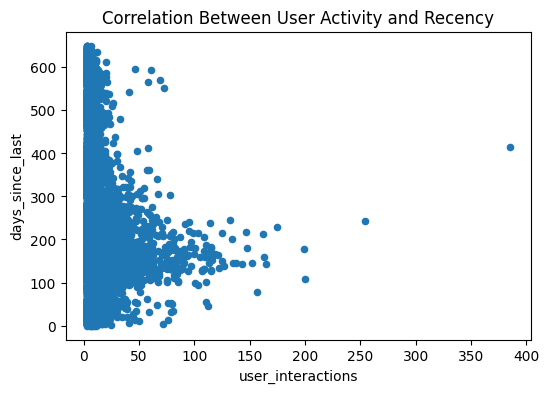


>>> Correlation: -0.20784158990512178


In [ ]:
recency_freq = pd.DataFrame({
    'user_interactions': user_counts,
    'last_interaction': interactions_train.groupby('user_id')['timestamp'].max()
})

recency_freq['days_since_last'] = (interactions_train['timestamp'].max() - recency_freq['last_interaction'])/86400

recency_freq.plot(kind='scatter', x='user_interactions', y='days_since_last', figsize=(6,4),
                  title='Correlation Between User Activity and Recency')
plt.show()

corr = recency_freq['user_interactions'].corr(recency_freq['days_since_last'])

print("\n>>> Correlation:", corr)

Negative correlation → users who interact more tend to have more recent interactions. It is not very strong so not *all* heavy users are recent, but there is a clear tendency.

There is a also single extreme outlier representing a user with ~400 interactions, whose last interaction occurred over ~400 days before the dataset stops. This individual is uncommon but probably not an error so we keep them in the dataset. Time-decay and normalization will reduce the influence of such rare cases.

## Time Decay (next notebook)

In [ ]:
# Normalize timestamps between 0 and 1
max_ts = interactions_train['timestamp'].max()
min_ts = interactions_train['timestamp'].min()
interactions_train['time_decay'] = np.exp(-0.1 * (max_ts - interactions_train['timestamp']) / (max_ts - min_ts))
interactions_train

,user_id,item_id,timestamp,datetime,year,month,day,week,day_of_week,time_diff,time_decay
0,4456,8581,1.687541e+09,2023-06-23 17:24:46,2023,6,23,25,4,41383968.0,0.929084
1,142,1964,1.679585e+09,2023-03-23 15:30:06,2023,3,23,12,3,49339648.0,0.916038
2,362,3705,1.706872e+09,2024-02-02 11:00:59,2024,2,2,5,4,22053395.0,0.961560
3,1809,11317,1.673533e+09,2023-01-12 14:19:22,2023,1,12,2,3,55391892.0,0.906237
4,4384,1323,1.681402e+09,2023-04-13 16:09:22,2023,4,13,15,3,47522892.0,0.919001
...,...,...,...,...,...,...,...,...,...,...,...
87042,924,8171,1.699284e+09,2023-11-06 15:15:47,2023,11,6,45,0,29641307.0,0.948679
87043,1106,9009,1.699872e+09,2023-11-13 10:48:13,2023,11,13,46,0,29052561.0,0.949672
87044,5207,13400,1.683627e+09,2023-05-09 10:02:52,2023,5,9,19,1,45298482.0,0.922642
87045,698,5779,1.686667e+09,2023-06-13 14:37:48,2023,6,13,24,1,42257986.0,0.927641
